### Comparing Remote Sensing Snow Depth at the Catchment and Sub-Catchment Scale

In [2]:
# Import Libraries
import rasterio
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt

from rasterio.mask import mask
from rasterio.plot import show
from rasterio.warp import reproject, Resampling
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from scipy.stats import spearmanr

Import Shapefiles

In [ ]:
# Import Navajo Catchment Shapefiles
fpath = '/Users/amarziliano/OneDrive - University of New Mexico/SNOW RESEARCH/SNOW DATA/Banded Peak Ranch/BPR GIS/GIS FILES/Basins & Catchments/Chama Basins/'
Nav_Catch = geopandas.read_file(fpath + 'NavajoRiver_Basin_toOsoDiv.shp', crs="epsg:4326")

# Import Site Area Shapefiles
fpath = '/Users/amarziliano/OneDrive - University of New Mexico/SNOW RESEARCH/SNOW DATA/Banded Peak Ranch/BPR GIS/GIS FILES/Survey Measurement Locations/SurveyAreaBoxes/'
Blind351 = geopandas.read_file(fpath + 'Blind351Box.shp', crs="epsg:4326")
Julies = geopandas.read_file(fpath + 'JuliesMeadowBox.shp', crs="epsg:4326")
NewMeadow = geopandas.read_file(fpath + 'NewMeadowBox.shp', crs="epsg:4326")

# Import SubPlot Shapefiles
#fpath = '/Users/amarziliano/OneDrive - University of New Mexico/SNOW RESEARCH/SNOW DATA/Banded Peak Ranch/BPR GIS/GIS FILES/Survey Measurement Locations/SurveyAreaBoxes/'
# TAB_1
# TAB_2
# TAB_3
# TAB_4


Import SNOTEL Data

In [ ]:
# Import SNOTEL Excel File
SNOTEL = pd.ExcelFile("/Users/Adrian/OneDrive - University of New Mexico/SNOW RESEARCH/SNOW DATA/Banded Peak Ranch/SNOTEL DATA/BPR_SNOTELs_2016-2023.xlsx")
cham = pd.read_excel(SNOTEL, 'Chamita')
cumb = pd.read_excel(SNOTEL, 'LilyPond')
lily = pd.read_excel(SNOTEL, 'CumbresTrestle')
wolf = pd.read_excel(SNOTEL, 'WolfCreek')

# Convert inches to meters
cham_m = cham['SnowDepth[in]'] * 0.0254
cumb_m = cumb['SnowDepth[in]'] * 0.0254
lily_m = lily['SnowDepth[in]'] * 0.0254
wolf_m = wolf['SnowDepth[in]'] * 0.0254

# Date
SNOTEL_Date = pd.to_datetime(cumb['Date'])

Import 2022 Snow Survey Data

In [ ]:
# Import 2022 Data
# Import Excel File and Excel Sheets to dataframes
SDxlsx = pd.ExcelFile("/Users/Adrian/OneDrive - University of New Mexico/SNOW RESEARCH/SNOW DATA/Banded Peak Ranch/SNOW SURVEY DATA/BandedPeakData2022.xlsx")
tab = pd.read_excel(SDxlsx, 'BPR_TAB')
ta2 = pd.read_excel(SDxlsx, 'BPR_TA2')
tcd = pd.read_excel(SDxlsx, 'BPR_TCD')

# Import Coordinates for depth points
tabcoords = pd.read_excel(SDxlsx, 'BPR_TAB', usecols='A:F')
ta2coords = pd.read_excel(SDxlsx, 'BPR_TA2', usecols='A:F')
tcdcoords = pd.read_excel(SDxlsx, 'BPR_TCD', usecols='A:F')

# Import Depth Points
SDtab = tab.drop(columns=["DepthPointID", "Lat", "Long", "UTME", "UTMN", "UTMZone"])
SDta2 = ta2.drop(columns=["DepthPointID", "Lat", "Long", "UTME", "UTMN", "UTMZone"])
SDtcd = tcd.drop(columns=["DepthPointID", "Lat", "Long", "UTME", "UTMN", "UTMZone"])

# Convert columns to datetime
SDtab.columns = pd.to_datetime(SDtab.columns)
SDta2.columns = pd.to_datetime(SDta2.columns)
SDtcd.columns = pd.to_datetime(SDtcd.columns)

# Import Transect Dates
TDates = list(SDtab.columns.values)

#df = pd.DataFrame(employees, columns =['Name', 'Age', 'City', 'Salary'])
#df.columns = pd.MultiIndex.from_tuples([('When', 'Date'), ('When', 'Time'), ('Country', 'USA'), ('Country', 'Canada'), ('Channel', 'SD'), ('Channel', 'HD')])

# Import Snow Pit Data
SP1 = pd.read_excel(SDxlsx, 'BPR_SP1')
SP1_Dates = SP1.drop_duplicates('Date')
SP1_Dates = SP1_Dates['Date'].values[0:]

SP2 = pd.read_excel(SDxlsx, 'BPR_SP2')
SP2_Dates = SP2.drop_duplicates('Date')
SP2_Dates = SP2_Dates['Date'].values[0:]

# Get 'shape' of Dataframes
shape_SDtab = SDtab.shape
shape_SDta2 = SDta2.shape
shape_SDtcd = SDtcd.shape
shape_SP1 = SP1_Dates.shape
shape_SP2 = SP2_Dates.shape

# Print Number of columns
print('Number of Transect TAB dates:', shape_SDtab[1])
print('Number of Transect TA2 dates:', shape_SDta2[1])
print('Number of Transect TCD dates:', shape_SDtcd[1])

print('Number of Snow Pit SP1 dates:', shape_SP1[0])
print('Number of Snow Pit SP3 dates:', shape_SP2[0])

#### Extract April 6, 2022 survey data for comparison with VHR and S1

#### Import S1 Snow Depth

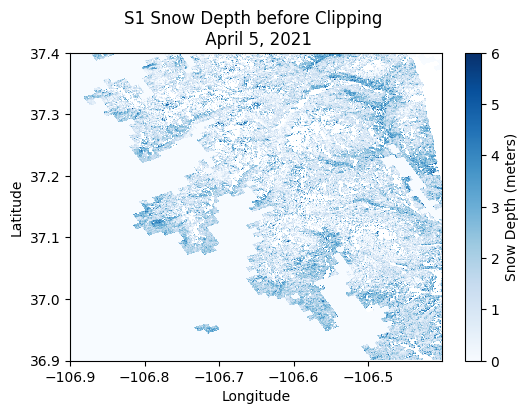

In [7]:
# Import April 5, 2021 S1 Snow Depth (SpicySnow)

def plot_and_export_snow_depth(nc_file_path, output_file_path):
    # Import NetCDF file using xarray
    ds = xr.open_dataset(nc_file_path)

    # Extract data for April 5, 2021
    selected_data = '2021-04-05'
    april_5_data = ds.sel(time=selected_data)

    # Extract variables
    x = april_5_data['x']
    y = april_5_data['y']

    # Squeeze the snow_depth variable to remove singleton dimension
    snow_depth = april_5_data['snow_depth'].squeeze()

    # Plotting
    plt.figure(figsize=(6, 4))
    plt.pcolormesh(x, y, snow_depth, shading='auto', cmap='Blues', vmin=0, vmax=6)
    plt.colorbar(label='Snow Depth (meters)')
    plt.title('S1 Snow Depth before Clipping \n April 5, 2021')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

    # Save the extracted data to a new NetCDF file
    april_5_data.to_netcdf(output_file_path)

    # Close the NetCDF dataset
    ds.close()

# Function usage
nc_file_path = '/Users/marzi/Desktop/BPR_snd2021.nc'
output_file_path = '/Users/marzi/Desktop/Apr52021_BPR_snd.nc'
plot_and_export_snow_depth(nc_file_path, output_file_path)

#### Import VHR Photogrammetry Snow Depth (April 9, 2022)

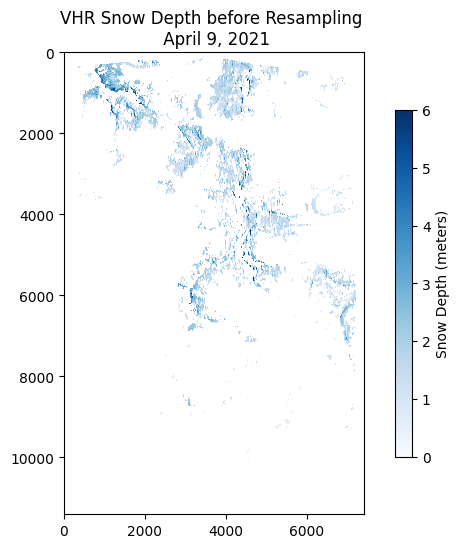

In [4]:
# Import Original VHR Snow Depth


# Path to your GeoTIFF file
file_path = '/Users/marzi/Desktop/WGS84_VHR.tif'

# Open the GeoTIFF file
with rasterio.open(file_path) as src:
    # Read the data
    snow_depth = src.read(1, masked=True)

    # Plot the GeoTIFF image
    plt.figure(figsize=(8, 6))
    img_plot = plt.imshow(snow_depth, cmap='Blues', vmin=0, vmax=6)

    # Add colorbar
    cbar = plt.colorbar(img_plot, shrink=0.75)
    cbar.set_label('Snow Depth (meters)')

    # Add title and labels
    plt.title('VHR Snow Depth before Resampling \n April 9, 2021')
    
    # Show the plot
    plt.show()


Compare VHR Snow Depth to S1 Snow Depth

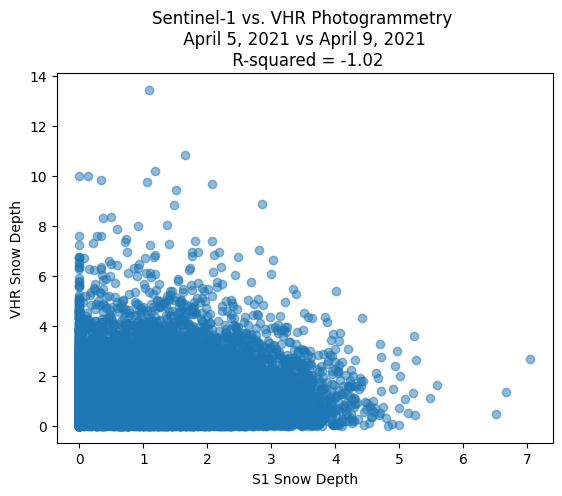

In [35]:
def analyze_r_squared(output_path, clip_extent_path):
    # Open the output GeoTIFF file for reading
    with rasterio.open(output_path) as output_src:
        # Open the clip extent GeoTIFF file for reading
        with rasterio.open(clip_extent_path) as clip_src:
            # Read the data from both files
            output_data = output_src.read(1)
            clip_data = clip_src.read(1)

            # Ensure both datasets have the same shape
            common_shape = (min(output_data.shape[0], clip_data.shape[0]), min(output_data.shape[1], clip_data.shape[1]))
            output_data = output_data[:common_shape[0], :common_shape[1]]
            clip_data = clip_data[:common_shape[0], :common_shape[1]]

            # Find pixels where both files have valid data
            valid_pixels = np.logical_and(~np.isnan(output_data), ~np.isnan(clip_data))

            # Extract data for valid pixels
            valid_output_data = output_data[valid_pixels]
            valid_clip_data = clip_data[valid_pixels]

            # Calculate the R-squared
            r_squared = r2_score(valid_output_data.flatten(), valid_clip_data.flatten())

            # Plotting
            plt.scatter(valid_output_data, valid_clip_data, alpha=0.5)
            plt.title(f'Sentinel-1 vs. VHR Photogrammetry \n April 5, 2021 vs April 9, 2021 \n R-squared = {r_squared:.2f}')
            plt.xlabel('S1 Snow Depth')
            plt.ylabel('VHR Snow Depth')
            plt.show()

# Function usage:
output_geotiff_path = '/Users/marzi/Desktop/clipped_Apr52021_S1snd.tif'
clip_extent_geotiff_path = '/Users/marzi/Desktop/resampled_VHR.tif'

analyze_r_squared(output_geotiff_path, clip_extent_geotiff_path)


### Pearson R Analysis: S1 vs VHR Snow Depth

Correlation Coefficient: 0.010870418485198725


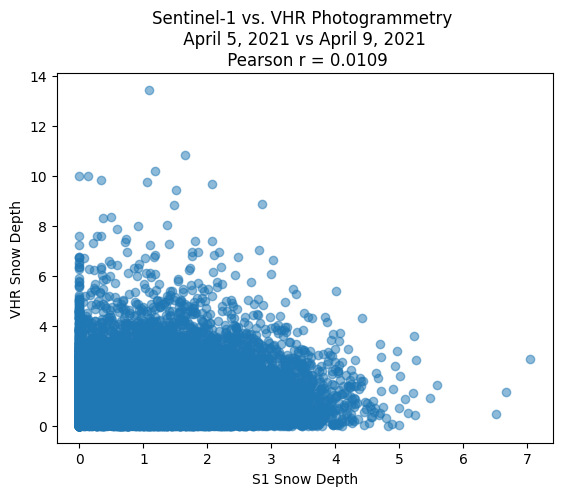

In [52]:

def analyze_correlation(output_path, clip_extent_path):
    # Open the output GeoTIFF file for reading
    with rasterio.open(output_path) as output_src:
        # Open the clip extent GeoTIFF file for reading
        with rasterio.open(clip_extent_path) as clip_src:
            # Read the data from both files
            output_data = output_src.read(1)
            clip_data = clip_src.read(1)

            # Ensure both datasets have the same shape
            common_shape = (min(output_data.shape[0], clip_data.shape[0]), min(output_data.shape[1], clip_data.shape[1]))
            output_data = output_data[:common_shape[0], :common_shape[1]]
            clip_data = clip_data[:common_shape[0], :common_shape[1]]

            # Find pixels where both files have valid data
            valid_pixels = np.logical_and(~np.isnan(output_data), ~np.isnan(clip_data))

            # Extract data for valid pixels
            valid_output_data = output_data[valid_pixels]
            valid_clip_data = clip_data[valid_pixels]

            # Calculate the correlation coefficient
            correlation_coefficient, _ = pearsonr(valid_output_data.flatten(), valid_clip_data.flatten())

            print(f'Correlation Coefficient: {correlation_coefficient}')

            # Plotting
            plt.scatter(valid_output_data, valid_clip_data, alpha=0.5)
            plt.title(f'Sentinel-1 vs. VHR Photogrammetry \n April 5, 2021 vs April 9, 2021 \n Pearson r = {correlation_coefficient:.4f}')
            plt.xlabel('S1 Snow Depth')
            plt.ylabel('VHR Snow Depth')
            plt.show()

# Example usage:
clip_extent_geotiff_path = '/Users/marzi/Desktop/resampled_VHR.tif'
output_geotiff_path = '/Users/marzi/Desktop/clipped_Apr52021_S1snd.tif'

analyze_correlation(output_geotiff_path, clip_extent_geotiff_path)





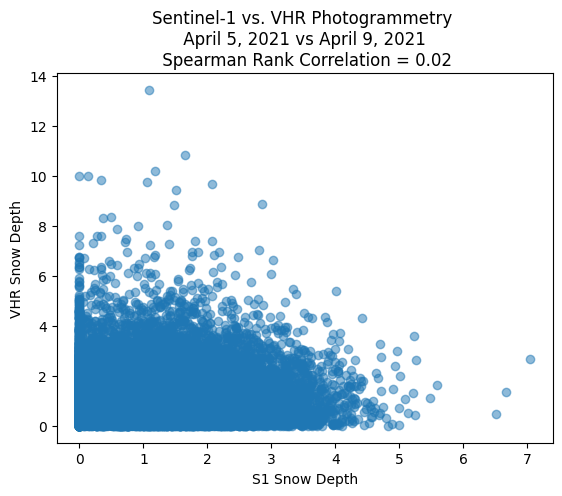

In [34]:
def analyze_spearman_correlation(output_path, clip_extent_path):
    # Open the output GeoTIFF file for reading
    with rasterio.open(output_path) as output_src:
        # Open the clip extent GeoTIFF file for reading
        with rasterio.open(clip_extent_path) as clip_src:
            # Read the data from both files
            output_data = output_src.read(1)
            clip_data = clip_src.read(1)

            # Ensure both datasets have the same shape
            common_shape = (min(output_data.shape[0], clip_data.shape[0]), min(output_data.shape[1], clip_data.shape[1]))
            output_data = output_data[:common_shape[0], :common_shape[1]]
            clip_data = clip_data[:common_shape[0], :common_shape[1]]

            # Find pixels where both files have valid data
            valid_pixels = np.logical_and(~np.isnan(output_data), ~np.isnan(clip_data))

            # Extract data for valid pixels
            valid_output_data = output_data[valid_pixels]
            valid_clip_data = clip_data[valid_pixels]

            # Calculate the Spearman correlation coefficient
            correlation_coefficient, _ = spearmanr(valid_output_data.flatten(), valid_clip_data.flatten())

            # Plotting
            plt.scatter(valid_output_data, valid_clip_data, alpha=0.5)
            plt.title(f'Sentinel-1 vs. VHR Photogrammetry \n April 5, 2021 vs April 9, 2021 \n Spearman Rank Correlation = {correlation_coefficient:.2f}')
            plt.xlabel('S1 Snow Depth')
            plt.ylabel('VHR Snow Depth')
            plt.show()

# Example usage:
output_geotiff_path = '/Users/marzi/Desktop/clipped_Apr52021_S1snd.tif'
clip_extent_geotiff_path = '/Users/marzi/Desktop/resampled_VHR.tif'

analyze_spearman_correlation(output_geotiff_path, clip_extent_geotiff_path)


Mean Snow Depth: 1.030079590913354


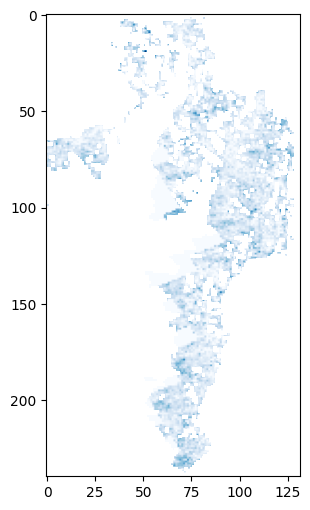

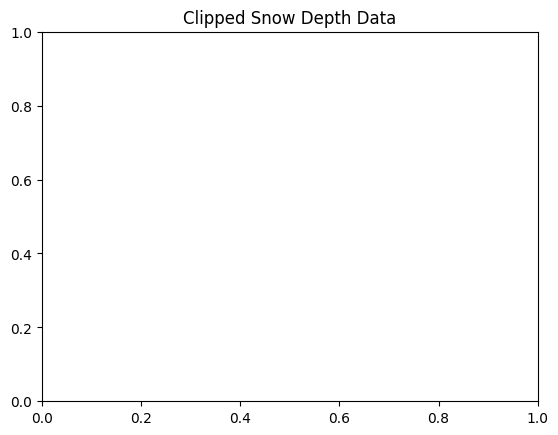

In [33]:
def clip_and_calculate_mean(input_geotiff, shapefile_path):
    # Open the GeoTIFF file
    with rasterio.open(input_geotiff) as src:
        # Read the shapefile
        shapefile = gpd.read_file(shapefile_path)
        
        # Clip the GeoTIFF to the shapefile geometry
        clipped_data, _ = mask(src, shapefile.geometry, crop=True)

        # Calculate the mean snow depth excluding nan values
        mean_snow_depth = np.nanmean(clipped_data)
        print(f"Mean Snow Depth: {mean_snow_depth}")

        # Plot the clipped data
        plt.figure(figsize=(10, 6))
        show(clipped_data, cmap='Blues')
        plt.title("Clipped Snow Depth Data")
        plt.show()

# Function usage:
input_geotiff = '/Users/marzi/Desktop/clipped_Apr52021_S1snd.tif'
shapefile_path = '/Users/marzi\OneDrive - University of New Mexico/SNOW RESEARCH\SNOW DATA/Banded Peak Ranch/BPR GIS/GIS FILES/CatchmentContours/NavajoBasin_AreaAbv3000m.shp'
clip_and_calculate_mean(input_geotiff, shapefile_path)

#tiff_file = '/Users/marzi/Desktop/resampled_VHR.tif'
#tiff_file = '/Users/marzi/Desktop/clipped_Apr52021_S1snd.tif'


Mean Snow Depth: 0.2745998799800873


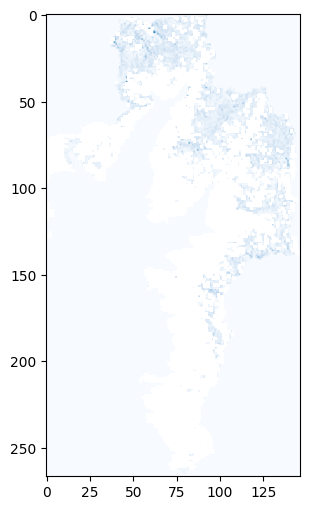

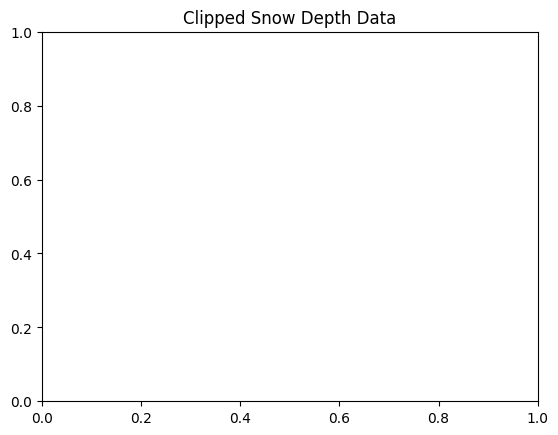

In [42]:
def clip_and_calculate_mean(input_geotiff, shapefile_path):
    # Open the GeoTIFF file
    with rasterio.open(input_geotiff) as src:
        # Read the shapefile
        shapefile = gpd.read_file(shapefile_path)
        
        # Clip the GeoTIFF to the shapefile geometry
        clipped_data, _ = mask(src, shapefile.geometry, crop=True)

        # Calculate the mean snow depth excluding nan values
        mean_snow_depth = np.nanmean(clipped_data)
        print(f"Mean Snow Depth: {mean_snow_depth}")

        # Plot the clipped data
        plt.figure(figsize=(10, 6))
        show(clipped_data, cmap='Blues')
        plt.title("Clipped Snow Depth Data")
        plt.show()

# Function usage:
input_geotiff = '/Users/marzi/Desktop/resampled_VHR.tif'
shapefile_path = '/Users/marzi\OneDrive - University of New Mexico/SNOW RESEARCH\SNOW DATA/Banded Peak Ranch/BPR GIS/GIS FILES/CatchmentContours/NavajoBasin_AreaAbv3000m.shp'
clip_and_calculate_mean(input_geotiff, shapefile_path)

Mean Snow Depth: 0.29648253321647644


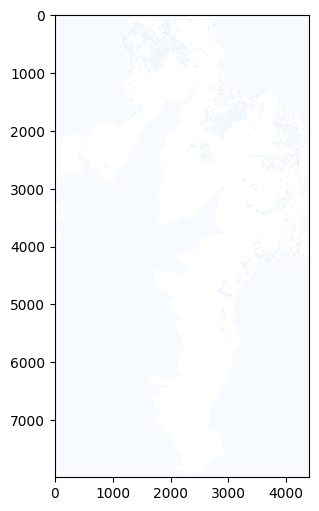

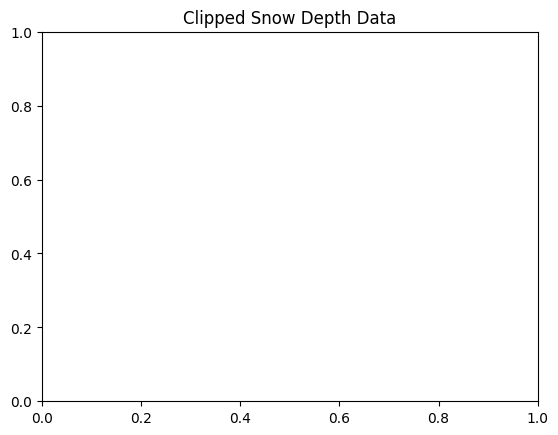

In [4]:
def clip_and_calculate_mean(input_geotiff, shapefile_path):
    # Open the GeoTIFF file
    with rasterio.open(input_geotiff) as src:
        # Read the shapefile
        shapefile = gpd.read_file(shapefile_path)
        
        # Clip the GeoTIFF to the shapefile geometry
        clipped_data, _ = mask(src, shapefile.geometry, crop=True)

        # Calculate the mean snow depth excluding nan values
        mean_snow_depth = np.nanmean(clipped_data)
        print(f"Mean Snow Depth: {mean_snow_depth}")

        # Plot the clipped data
        plt.figure(figsize=(10, 6))
        show(clipped_data, cmap='Blues')
        plt.title("Clipped Snow Depth Data")
        plt.show()

# Function usage:
input_geotiff = '/Users/marzi/Desktop/WGS84_VHR.tif'
shapefile_path = '/Users/marzi\OneDrive - University of New Mexico/SNOW RESEARCH\SNOW DATA/Banded Peak Ranch/BPR GIS/GIS FILES/CatchmentContours/NavajoBasin_AreaAbv3000m.shp'
clip_and_calculate_mean(input_geotiff, shapefile_path)